# Times Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv(r"archive\PJME_hourly.csv")

color_pal = sns.color_palette()

df['Datetime'] = pd.to_datetime(df['Datetime'])

df.set_index('Datetime',inplace=True)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


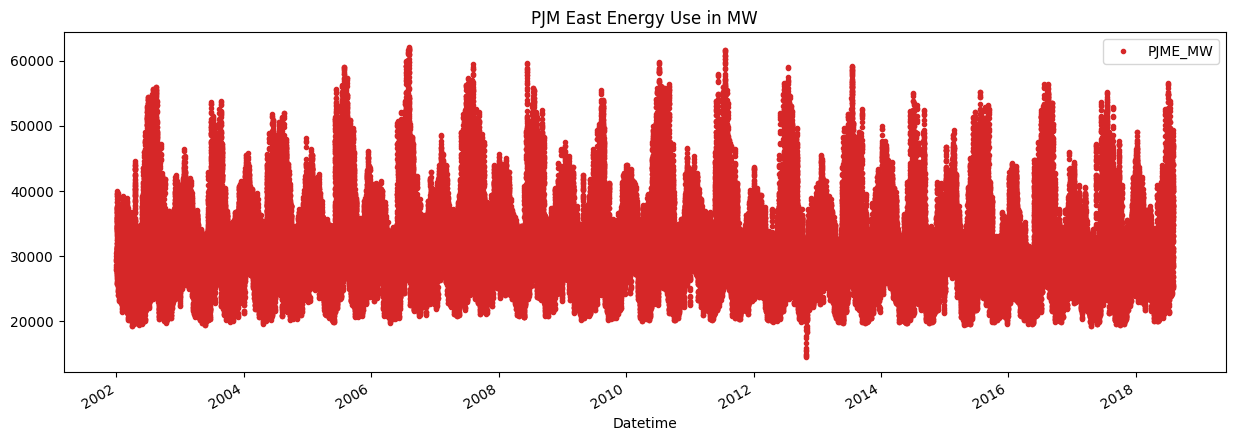

In [4]:
df.plot(style='.',figsize=(15,5),color=color_pal[3], title='PJM East Energy Use in MW')
plt.show()

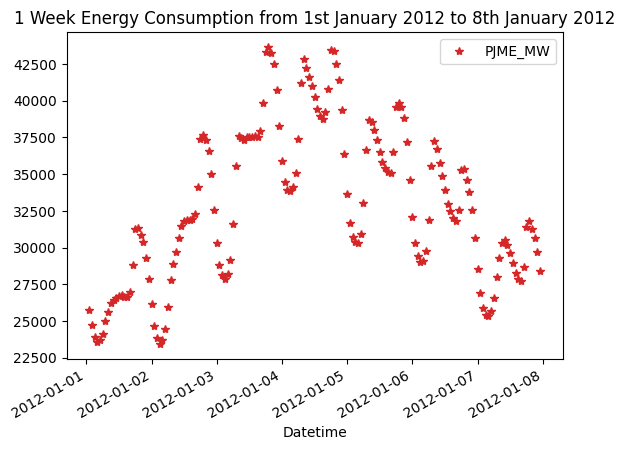

In [5]:
df[(df.index>'2012-01-01') & (df.index<'2012-01-08')].plot(style='*',color=color_pal[3])
plt.title('1 Week Energy Consumption from 1st January 2012 to 8th January 2012')

plt.show()

## Train/Test/Split

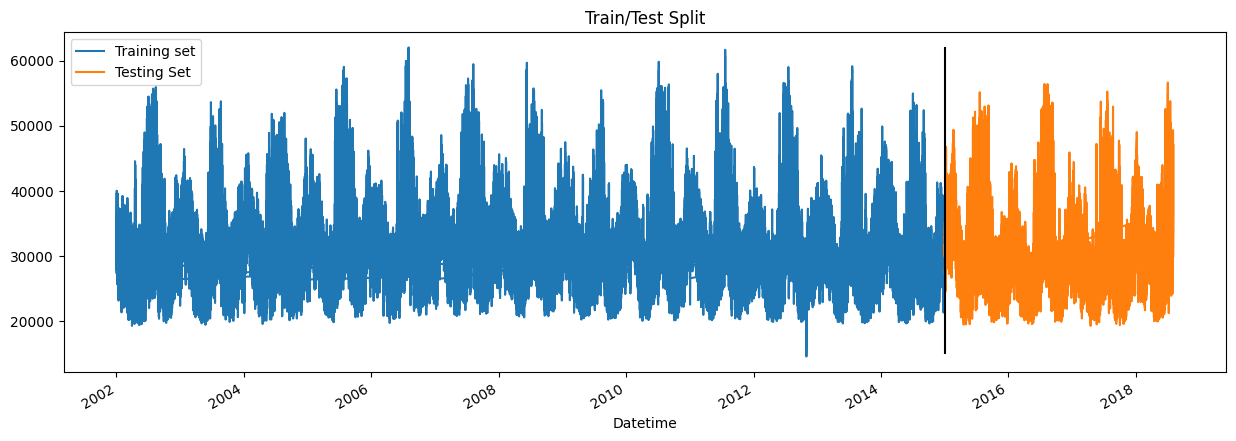

In [6]:
train = df[df.index<'2015-01-01']  # training dataset are the energy consumption values before 1st January 2015
test = df[df.index>='2015-01-01']  # test dataset are the energy consumption values on and after 1st January 2015

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Set',title='Train/Test Split')
test.plot(ax=ax,label='Testing Set')

ax.vlines(x='2015-01-01',ymin=15000,ymax=df.max(),colors='black')
ax.legend(['Training set','Testing Set'])

plt.show()

## Feature Enegineering

In [7]:
def create_features(df):
    """Create time series features based on time series index"""    

    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    return df

In [8]:
create_features(df)

,PJME_MW,hour,day,day_of_week,quarter,year,month
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,31,1,4,2002,12
2002-12-31 02:00:00,25147.0,2,31,1,4,2002,12
2002-12-31 03:00:00,24574.0,3,31,1,4,2002,12
2002-12-31 04:00:00,24393.0,4,31,1,4,2002,12
2002-12-31 05:00:00,24860.0,5,31,1,4,2002,12
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,1,0,1,2018,1
2018-01-01 21:00:00,43751.0,21,1,0,1,2018,1
2018-01-01 22:00:00,42402.0,22,1,0,1,2018,1


## Visualise feature \ Target Relationship

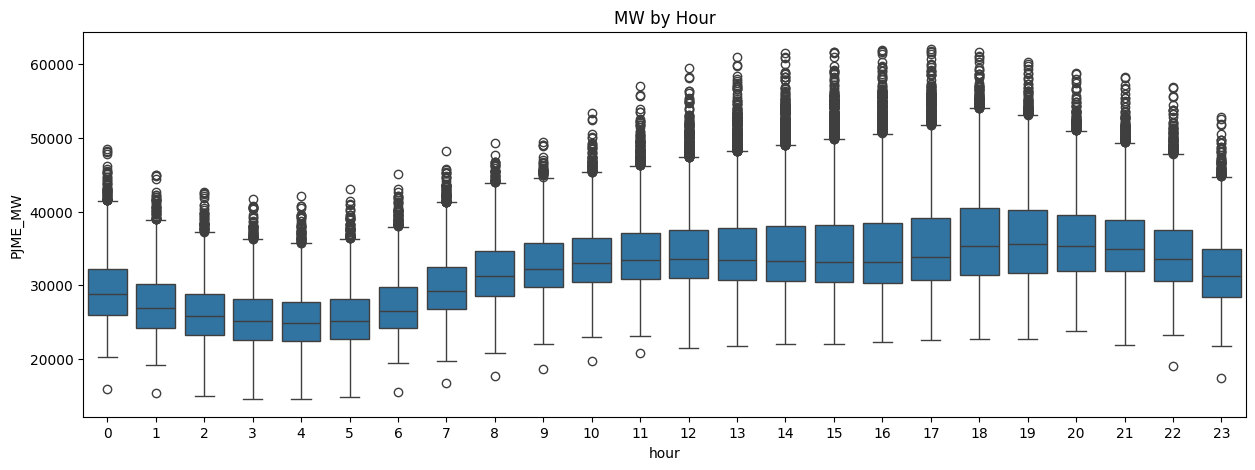

In [9]:
fig , ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by Hour')

plt.show()

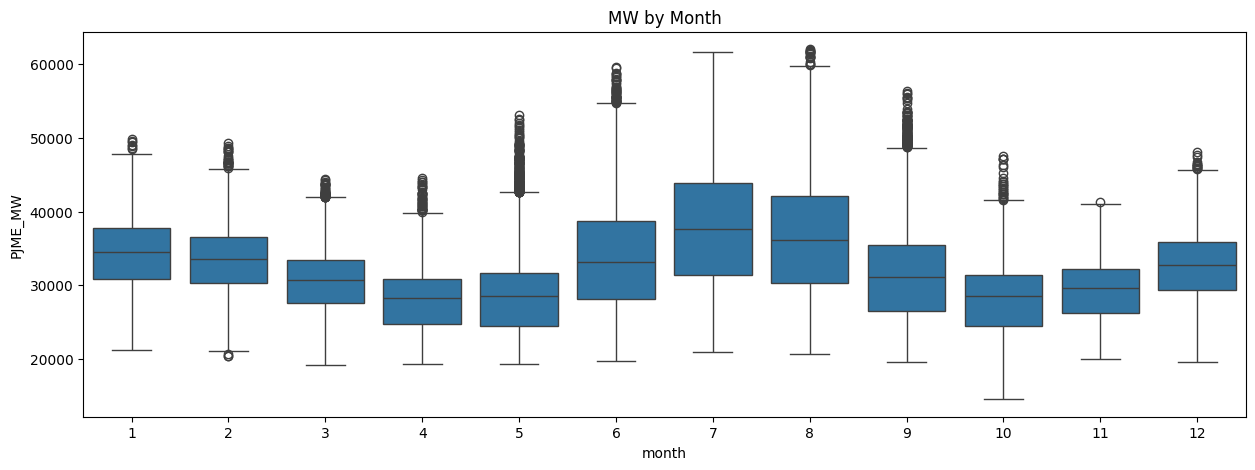

In [10]:
fig , ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='month',y='PJME_MW')
ax.set_title('MW by Month')

plt.show()

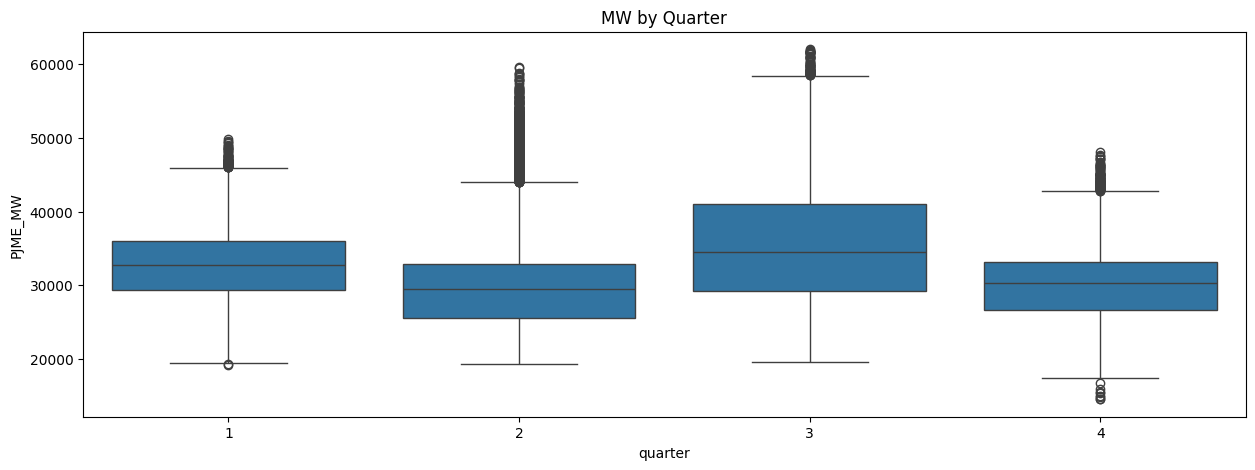

In [11]:
fig , ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='quarter',y='PJME_MW')
ax.set_title('MW by Quarter')

plt.show()

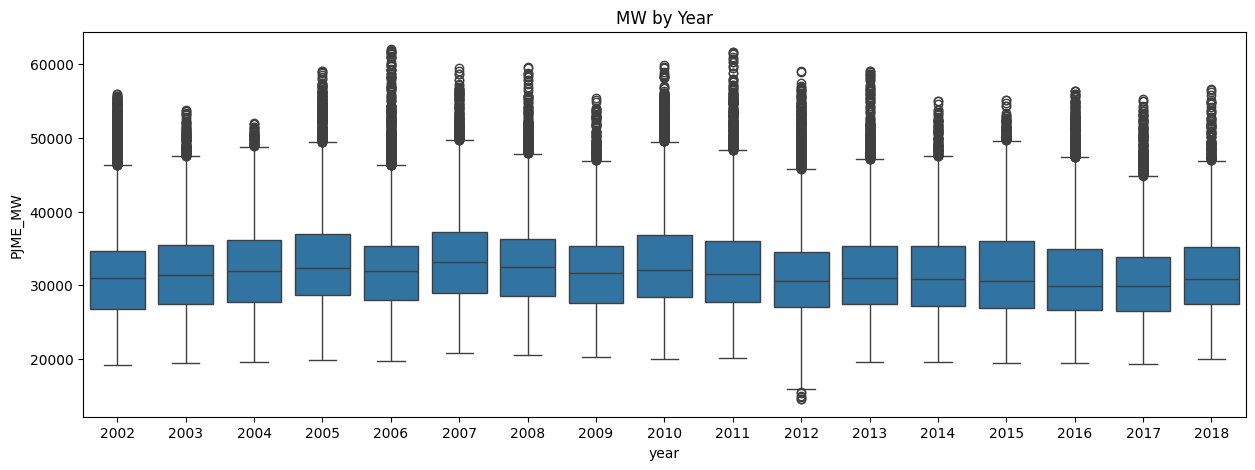

In [12]:
fig , ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df,x='year',y='PJME_MW')
ax.set_title('MW by Year')

plt.show()

## Create XGBoost Model

In [13]:
train = create_features(train)
test = create_features(test)

features = ['hour', 'day', 'day_of_week', 'quarter', 'year', 'month']
target = 'PJME_MW'

C:\Users\chukw\AppData\Local\Temp\ipykernel_33308\1386434478.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\chukw\AppData\Local\Temp\ipykernel_33308\1386434478.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df.index.day
C:\Users\chukw\AppData\Local\Temp\ipykernel_33308\1386434478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [14]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [15]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train), (X_test,y_test)],
        verbose=20)

[0]	validation_0-rmse:6408.45643	validation_1-rmse:6480.69238
[20]	validation_0-rmse:5649.73694	validation_1-rmse:5783.00198
[40]	validation_0-rmse:5072.88183	validation_1-rmse:5274.44613
[60]	validation_0-rmse:4620.46851	validation_1-rmse:4877.96254
[80]	validation_0-rmse:4276.23942	validation_1-rmse:4590.25169
[100]	validation_0-rmse:4022.10204	validation_1-rmse:4388.35839
[120]	validation_0-rmse:3826.20707	validation_1-rmse:4242.47926
[140]	validation_0-rmse:3677.07498	validation_1-rmse:4141.49592
[160]	validation_0-rmse:3562.12817	validation_1-rmse:4064.69838
[180]	validation_0-rmse:3465.82456	validation_1-rmse:4001.60435
[200]	validation_0-rmse:3390.64299	validation_1-rmse:3952.05576
[220]	validation_0-rmse:3324.32482	validation_1-rmse:3907.18632
[240]	validation_0-rmse:3273.45747	validation_1-rmse:3878.90403
[260]	validation_0-rmse:3229.17567	validation_1-rmse:3853.30134
[280]	validation_0-rmse:3186.97633	validation_1-rmse:3834.46912
[300]	validation_0-rmse:3146.26855	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Freature Importance

In [16]:
importance = pd.DataFrame(reg.feature_importances_,reg.feature_names_in_)
importance.sort_values(by=0,ascending=True,inplace=True)
importance.rename(columns={0:'importances'},inplace=True)
importance

,importances
day,0.022663
year,0.025477
quarter,0.095055
month,0.166469
day_of_week,0.179473
hour,0.510863


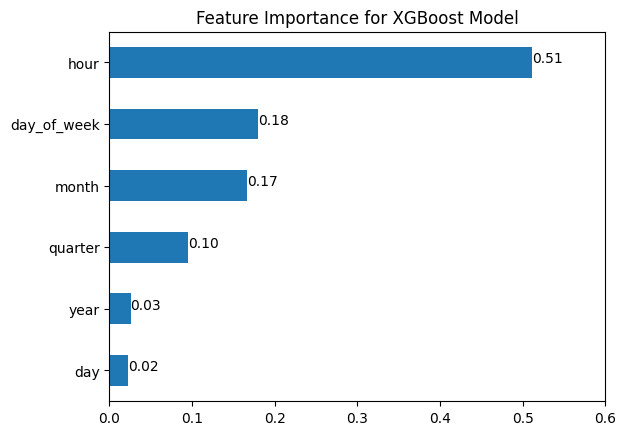

In [17]:
importance.sort_values(by='importances',ascending=True).plot(kind='barh',title="Feature Importance for XGBoost Model",legend=False)

for i,value in enumerate(importance['importances']):
    plt.text(x=value,y=i,s=f'{value:.2f}')

x_tick = np.arange(0,0.7,0.1)
plt.xticks(x_tick)

plt.show()

## Forecast on Test 

In [18]:
test['prediction'] =  reg.predict(X_test)
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)
df.head()

C:\Users\chukw\AppData\Local\Temp\ipykernel_33308\951660960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] =  reg.predict(X_test)


,PJME_MW,hour,day,day_of_week,quarter,year,month,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,31,1,4,2002,12,NaN
2002-12-31 02:00:00,25147.0,2,31,1,4,2002,12,NaN
2002-12-31 03:00:00,24574.0,3,31,1,4,2002,12,NaN
2002-12-31 04:00:00,24393.0,4,31,1,4,2002,12,NaN
2002-12-31 05:00:00,24860.0,5,31,1,4,2002,12,NaN


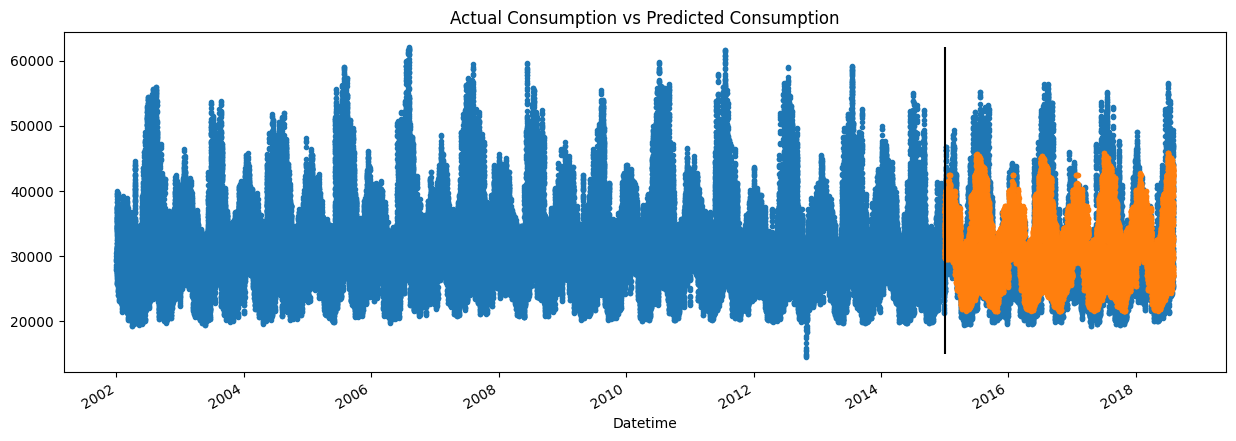

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
df['PJME_MW'].plot(ax=ax, style='.',title='Actual Consumption vs Predicted Consumption')
df['prediction'].plot(ax=ax, style='.')
ax.vlines(x='2015-01-01',ymin=15000,ymax=df['PJME_MW'].max(),colors='black')

plt.show()

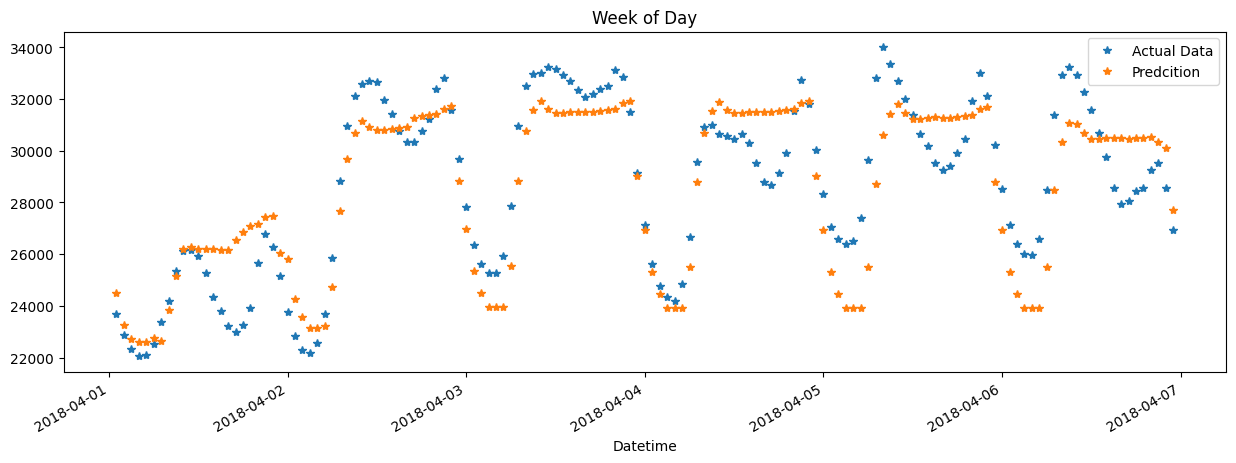

In [20]:
ax = df.loc[(df.index>'2018-04-01') & (df.index<'2018-04-07')]['PJME_MW']\
    .plot(figsize=(15,5), style='*',title='Week of Day')

df.loc[(df.index>'2018-04-01') & (df.index<'2018-04-07')]['prediction']\
    .plot(figsize=(15,5), style='*')

plt.legend(['Actual Data','Predcition'])
plt.show()

## Evaluation

In [21]:
# to find the RMSE 
# this was the same metrics used in the XGBRegressor 

mse = mean_squared_error(test['PJME_MW'],test['prediction'])
rmse = np.sqrt(mse)
print(f'RMSE Score on test dataset is {rmse:,.2f}')

RMSE Score on test dataset is 3,789.04


## Calculate Error

In [22]:
test['error'] = round((np.absolute(test['PJME_MW']-test['prediction'])),2)
test

C:\Users\chukw\AppData\Local\Temp\ipykernel_33308\4060784154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = round((np.absolute(test['PJME_MW']-test['prediction'])),2)


,PJME_MW,hour,day,day_of_week,quarter,year,month,prediction,error
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,1,3,1,2015,1,31846.583984,955.42
2015-12-31 01:00:00,24305.0,1,31,3,4,2015,12,28312.087891,4007.09
2015-12-31 02:00:00,23156.0,2,31,3,4,2015,12,27161.671875,4005.67
2015-12-31 03:00:00,22514.0,3,31,3,4,2015,12,26873.634766,4359.63
2015-12-31 04:00:00,22330.0,4,31,3,4,2015,12,26873.634766,4543.63
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,1,0,1,2018,1,37863.410156,6420.59
2018-01-01 21:00:00,43751.0,21,1,0,1,2018,1,37488.023438,6262.98
2018-01-01 22:00:00,42402.0,22,1,0,1,2018,1,36144.812500,6257.19


## Look at the Worst and Best Predicted Days

In [23]:
test['date'] = test.index.date
test.head()


C:\Users\chukw\AppData\Local\Temp\ipykernel_33308\1293431641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index.date


,PJME_MW,hour,day,day_of_week,quarter,year,month,prediction,error,date
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,1,3,1,2015,1,31846.583984,955.42,2015-01-01
2015-12-31 01:00:00,24305.0,1,31,3,4,2015,12,28312.087891,4007.09,2015-12-31
2015-12-31 02:00:00,23156.0,2,31,3,4,2015,12,27161.671875,4005.67,2015-12-31
2015-12-31 03:00:00,22514.0,3,31,3,4,2015,12,26873.634766,4359.63,2015-12-31
2015-12-31 04:00:00,22330.0,4,31,3,4,2015,12,26873.634766,4543.63,2015-12-31


### Best Predicted Days

In [24]:
best_predictions = test.groupby('date')['error'].mean().sort_values(ascending=True)
best_predictions.head()

date
2015-05-06    334.455833
2016-12-30    378.675000
2016-03-20    403.277083
2016-01-12    463.451667
2016-10-27    467.219167
Name: error, dtype: float64

### Worst Predicted Days

In [25]:
worst_predictions = test.groupby('date')['error'].mean().sort_values(ascending=False)
worst_predictions.head()

date
2016-08-13    14210.808750
2016-08-14    14075.476250
2016-09-10    11652.767917
2016-09-09    11421.509167
2016-08-12    10954.813750
Name: error, dtype: float64